Evaluating models trained on v2.1 on v2.1 and v2.4

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# imports
from pathlib import Path
from typing import *

import pandas as pd
import srsly
import swifter
import wandb
from datasets import load_from_disk
from hydra.utils import instantiate
from omegaconf import OmegaConf
from tqdm.auto import tqdm

pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
from polyfuzz import PolyFuzz
from polyfuzz.models import TFIDF, EditDistance
from rapidfuzz import fuzz
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

from src.data.utilities import (
    check_dict_equal,
    clean_slot_values,
    clean_time,
    complement_labels,
    diff_train,
    extract_domains,
    extract_slots,
    extract_values,
    remove_empty_slots,
)
from src.evaluation import compute_prf, diff, jga, prepare_states_eval, slot_metrics
from src.model import DSTTask

In [4]:
list_dfs = []
path = Path("../preds")

for exp_path in list(path.rglob("*somdst_format")):

    for p in tqdm(list(exp_path.rglob("*preds.parquet")), desc=exp_path.name):

        # load
        df = pd.read_parquet(p).assign(
            split=p.parents[0].name,
            epoch=int(p.parents[1].name.split("=")[1]),
            version=p.parents[2].name,
            model=p.parents[4].name,
            size=p.parents[5].name,
        )

        # extract slots from experiments with normal states
        df = df.assign(
            states=lambda df_: df_["states"].map(remove_empty_slots),
            previous_states=lambda df_: df_["previous_states"].map(remove_empty_slots),
        )

        list_dfs.append(df)

somdst_format:   0%|          | 0/107 [00:00<?, ?it/s]

In [5]:
df = pd.concat(list_dfs).reset_index(drop=True)
df.groupby(["model", "split", "version"])[["epoch", "dialogue_id"]].nunique()

epoch  \
model                                       split      version          
mwoz21_ops_somdst_2022-12-21T23-48-52       test       v0          20   
                                                       v1          20   
                                            validation v0           7   
                                                       v1          20   
mwoz21_ops_somdst_lower_2022-12-21T23-50-46 test       v1          20   
                                            validation v1          20   

                                                                dialogue_id  
model                                       split      version               
mwoz21_ops_somdst_2022-12-21T23-48-52       test       v0              1000  
                                                       v1              1000  
                                            validation v0              1000  
                                                       v1              1000  
mwoz21_ops_somdst_lower_2022-12-21T23-50-46 test       v1              1000  
                                            validation v1              1000

In [6]:
df = df.loc[df["version"] == "v1"].copy()

In [10]:
def remove_empty(state):
    new_state = {k: v for k, v in state.items() if v != "none"}
    if len(new_state) < 1:
        return None
    return new_state

In [13]:
df["states"] = df["states"].swifter.apply(remove_empty)

Pandas Apply:   0%|          | 0/669840 [00:00<?, ?it/s]

In [93]:
# load gold annotations
list_dfs = []
for v in ("21", "24"):
    dataset_dict = load_from_disk(f"../data/processed/multiwoz_{v}")

    true_df = (
        pd.concat([dataset_dict[split].to_pandas() for split in ("test", "validation")])[
            ["dialogue_id", "turn_id", "states"]
        ]
        .sort_values(["dialogue_id", "turn_id"])
        .reset_index(drop=True)
        .assign(
            states=lambda df_: df_[f"states"].map(lambda ex: prepare_states_eval(remove_empty_slots(ex))), version=v
        )
    )

    list_dfs.append(true_df)

true_df = pd.concat(list_dfs).reset_index(drop=True)
true_df = true_df.set_index(["dialogue_id", "turn_id", "version"]).unstack(-1)
true_df.columns = [f"{i}_{j}" for i, j in true_df.columns]
true_df = true_df.reset_index()

In [94]:
def fix_labels(ex):
    new_state = {**ex}
    for k, v_list in ex.items():
        for v in v_list:
            if "guesthouse" in v:
                new_state[k].append(v.replace("guesthouse", "guest house"))

            elif "guest house" in v:
                new_state[k].append(v.replace("guest house", "guesthouse"))

    return new_state

In [97]:
fix_labels({"a": ["guesthouse"]})

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_28360/2205375211.py:1 in <module>                                                 │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_28360/2205375211.py'                        │
│                                                                                                  │
│ /tmp/ipykernel_28360/248479837.py:9 in fix_labels                                                │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_28360/248479837.py'                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyboardInterrupt

In [95]:
true_df["states_24"] = true_df["states_24"].swifter.apply(fix_labels)
true_df["states_22"] = true_df["states_22"].swifter.apply(fix_labels)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /home/lescipi/miniconda3/envs/skg/lib/python3.9/site-packages/swifter/swifter.py:309 in apply    │
│                                                                                                  │
│   306 │   │                                                                                      │
│   307 │   │   try:  # try to vectorize                                                           │
│   308 │   │   │   with suppress_stdout_stderr_logging():                                         │
│ ❱ 309 │   │   │   │   tmp_df = func(sample, *args, **kwds)                                       │
│   310 │   │   │   │   sample_df = sample.apply(func, convert_dtype=convert_dtype, args=args, *   │
│   311 │   │   │   │   self._validate_apply(                                                      │
│   312 │   │   │   │   │   np.array_equal(sample_df, tmp_df) & (hasattr(tmp_df, "shape")) & (sa   │
│                                                                                                  │
│ /tmp/ipykernel_28360/248479837.py:4 in fix_labels                                                │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_28360/248479837.py'                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: 'NoneType' object is not iterable

During handling of the above exception, another exception occurred:

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_28360/420820301.py:1 in <module>                                                  │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_28360/420820301.py'                         │
│                                                                                                  │
│ /home/lescipi/miniconda3/envs/skg/lib/python3.9/site-packages/swifter/swifter.py:318 in apply    │
│                                                                                                  │
│   315 │   │   │   return func(self._obj, *args, **kwds)                                          │
│   316 │   │   except ERRORS_TO_HANDLE:  # if can't vectorize, estimate time to pandas apply      │
│   317 │   │   │   wrapped = self._wrapped_apply(func, convert_dtype=convert_dtype, args=args,    │
│ ❱ 318 │   │   │   timed = timeit.timeit(wrapped, number=N_REPEATS)                               │
│   319 │   │   │   sample_proc_est = timed / N_REPEATS                                            │
│   320 │   │   │   est_apply_duration = sample_proc_est / self._SAMPLE_SIZE * self._nrows         │
│   321                                                                                            │
│                                                                                                  │
│ /home/lescipi/miniconda3/envs/skg/lib/python3.9/timeit.py:233 in timeit                          │
│                                                                                                  │
│   230 def timeit(stmt="pass", setup="pass", timer=default_timer,                                 │
│   231 │   │      number=default_number, globals=None):                                           │
│   232 │   """Convenience function to create Timer object and call timeit method."""              │
│ ❱ 233 │   return Timer(stmt, setup, timer, globals).timeit(number)                               │
│   234                                                                                            │
│   235 def repeat(stmt="pass", setup="pass", timer=default_timer,                                 │
│   236 │   │      repeat=default_repeat, numbe

In [54]:
schema = set(i for j in true_df["states_24"].map(extract_slots).tolist() for i in j)

In [55]:
df["new_states"] = df["states"].map(lambda ex: {k: v for k, v in ex.items() if k in schema} if ex is not None else None)

In [56]:
slots = set(i for j in df["new_states"].map(extract_slots).tolist() for i in j)

In [57]:
df["slots"] = df["new_states"].map(extract_slots)

In [58]:
a = df.groupby("epoch")["slots"].agg(lambda ex: set(i for j in ex.tolist() for i in j)).to_frame("slots")

In [59]:
a["diff"] = a["slots"].map(lambda ex: set(ex).difference(schema))

In [60]:
a

,slots,diff
epoch,,
0,"{train-arriveby, train-leaveat, hotel-name, taxi-destination, hotel-day, train-day, train-people, hotel-parking, hotel-stay, train-destination, restaurant-food, hotel-stars, restaurant-area, train-departure, hotel-people, attraction-area, taxi-arriveby, taxi-departure, attraction-name, restaurant-name, restaurant-people, taxi-leaveat, attraction-type, restaurant-day, restaurant-time, hotel-type, hotel-pricerange, hotel-area, restaurant-pricerange, hotel-internet}",{}
1,"{train-arriveby, train-leaveat, hotel-name, taxi-destination, hotel-day, train-day, train-people, hotel-parking, hotel-stay, train-destination, restaurant-food, hotel-stars, restaurant-area, train-departure, hotel-people, attraction-area, taxi-departure, taxi-arriveby, attraction-name, restaurant-name, restaurant-people, taxi-leaveat, attraction-type, restaurant-day, hotel-pricerange, restaurant-time, hotel-type, hotel-area, restaurant-pricerange, hotel-internet}",{}
2,"{train-arriveby, train-leaveat, hotel-name, taxi-destination, hotel-day, train-day, train-people, hotel-stay, hotel-parking, train-destination, restaurant-food, hotel-stars, restaurant-area, train-departure, hotel-people, attraction-area, taxi-departure, taxi-arriveby, attraction-name, restaurant-name, restaurant-people, taxi-leaveat, attraction-type, restaurant-day, hotel-pricerange, hotel-type, restaurant-time, hotel-area, restaurant-pricerange, hotel-internet}",{}
3,"{train-arriveby, train-leaveat, hotel-name, taxi-destination, hotel-day, train-day, train-people, hotel-parking, hotel-stay, train-destination, restaurant-food, hotel-stars, restaurant-area, train-departure, hotel-people, attraction-area, taxi-departure, taxi-arriveby, attraction-name, restaurant-name, restaurant-people, taxi-leaveat, attraction-type, restaurant-day, hotel-pricerange, hotel-type, restaurant-time, hotel-area, restaurant-pricerange, hotel-internet}",{}
4,"{train-arriveby, train-leaveat, hotel-name, taxi-destination, hotel-day, train-day, train-people, hotel-parking, hotel-stay, train-destination, restaurant-food, hotel-stars, restaurant-area, train-departure, hotel-people, attraction-area, taxi-departure, taxi-arriveby, attraction-name, restaurant-name, restaurant-people, taxi-leaveat, attraction-type, restaurant-day, hotel-pricerange, hotel-type, restaurant-time, hotel-area, restaurant-pricerange, hotel-internet}",{}
5,"{train-arriveby, train-leaveat, hotel-name, taxi-destination, hotel-day, train-day, train-people, hotel-parking, hotel-stay, train-destination, restaurant-food, hotel-stars, restaurant-area, train-departure, hotel-people, attraction-area, taxi-departure, taxi-arriveby, attraction-name, restaurant-name, restaurant-people, taxi-leaveat, attraction-type, restaurant-day, hotel-pricerange, hotel-type, restaurant-time, hotel-area, restaurant-pricerange, hotel-internet}",{}
6,"{train-arriveby, train-leaveat, hotel-name, taxi-destination, hotel-day, train-day, train-people, hotel-stay, hotel-parking, train-destination, restaurant-food, hotel-stars, restaurant-area, train-departure, hotel-people, attraction-area, taxi-departure, taxi-arriveby, attraction-name, restaurant-name, restaurant-people, taxi-leaveat, attraction-type, restaurant-day, hotel-pricerange, hotel-type, restaurant-time, hotel-area, restaurant-pricerange, hotel-internet}",{}
7,"{train-arriveby, train-leaveat, hotel-name, taxi-destination, hotel-day, train-day, train-people, hotel-parking, hotel-stay, train-destination, restaurant-food, hotel-stars, restaurant-area, train-departure, hotel-people, attraction-area, taxi-departure, taxi-arriveby, attraction-name, restaurant-name, restaurant-people, taxi-leaveat, attraction-type, restaurant-day, hotel-pricerange, hotel-type, restaurant-time, hotel-area, restaurant-pricerange, hotel-internet}",{}
8,"{train-arriveby, train-leaveat, hotel-name, taxi-destination, hotel-day, train-day, train-people, hotel-parking, hotel-stay, train-destination, restaurant-food, hotel-stars, res

In [15]:
# THIS IS FOR LATER
# def f(a, b):
#     if a is None or b is None:
#         return ()

#     diffs = {}
#     for k in a:
#         if k not in b:
#             continue
#         d = tuple(set(a[k]).symmetric_difference(set(b[k])))
#         if len(d) > 0:
#             diffs[k] = d

#     return tuple(diffs.items())

# true_df["diffs"] = true_df.apply(lambda row: f(row["states_22"], row["states_24"]), axis=1)
# m = true_df["diffs"].explode().dropna().to_frame("diffs")
# m["l"] = m["diffs"].map(lambda ex: len(ex[1]))
# m = m.loc[m["l"] > 1]
# m.drop_duplicates()

In [61]:
# add gold annotations
pred_df = pd.merge(
    df,
    true_df,
    on=["dialogue_id", "turn_id"],
    how="inner",
)
assert len(df) == len(pred_df)

In [63]:
# compute correct predictions
for v in ("21", "24"):
    pred_df[f"jga_turn_{v}"] = pred_df.swifter.apply(
        lambda row: jga(row["new_states"], row[f"states_{v}"]),
        axis=1,
    )

Pandas Apply:   0%|          | 0/669840 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/669840 [00:00<?, ?it/s]

---
### Run-time

In [18]:
tmp = pred_df["model"].str.split("_", expand=True)
pred_df["state_repr"] = tmp[1].str.strip()
pred_df["context"] = tmp[2].str.strip()
del tmp

In [19]:
pred_df["size"] = "base"
large = [p.name for p in Path("../preds/experiment_1/large/").iterdir()]
pred_df.loc[pred_df["model"].isin(large), "size"] = "large"

In [20]:
pred_df["runtime_instance"] = pred_df["runtime"] / pred_df["batch_size"]

In [21]:
t = pred_df.loc[pred_df["size"] == "base"]
rt = t.groupby(["state_repr", "context"])["runtime_instance"].agg(["median", "std"])

In [22]:
rt["relative"] = rt["median"] / rt["median"].min()

In [23]:
rt

,,median,std,relative
state_repr,context,,,
ops,somdst,0.142527,0.075946,1.0


In [ ]:
t = pred_df.loc[pred_df["size"] == "large"]
rt = t.groupby(["state_repr", "context"])["runtime_instance"].agg
a = (rt / rt.min()).reset_index().assign(size="large")

t = pred_df.loc[pred_df["size"] == "base"]
rt = pred_df.groupby(["state_repr", "context"])["runtime_instance"].median()
b = (rt / rt.min()).reset_index().assign(size="base")

runtime = pd.concat([a, b])
runtime

---

### Model selection and results

In [64]:
eval_cols = [
    "jga_turn_21",
    "jga_turn_24",
]

index_cols = [
    "model",
    "epoch",
    "version",
    "size",
]

In [65]:
val_df = (
    pred_df.loc[pred_df["split"] == "validation", eval_cols + index_cols]
    .groupby(index_cols)[eval_cols]
    .mean()
    .reset_index()
)

val_df = (
    val_df.groupby(["model", "version"])
    .apply(lambda df_: df_.set_index(["epoch"])[eval_cols].idxmax())
    .reset_index()
    .melt(id_vars=["model", "version"], var_name="metric", value_name="epoch")
)

In [66]:
test_df = (
    pred_df.loc[pred_df["split"] == "test", eval_cols + index_cols]
    .groupby(index_cols)[eval_cols]
    .mean()
    .reset_index()
    .melt(id_vars=index_cols, var_name="metric")
)

In [67]:
best_test_val = pd.merge(
    test_df,
    val_df,
    on=["model", "version", "epoch", "metric"],
    how="inner",
).set_index(["model", "version", "epoch", "metric", "size"])

best_test = test_df.groupby(["model", "version", "metric", "size"]).max().drop(columns=["epoch"])

In [73]:
best_test_val

,,,,,value
model,version,epoch,metric,size,
mwoz21_ops_somdst_2022-12-21T23-48-52,v1,15,jga_turn_21,base,0.507883
mwoz21_ops_somdst_lower_2022-12-21T23-50-46,v1,15,jga_turn_21,base,0.502150
mwoz21_ops_somdst_2022-12-21T23-48-52,v1,9,jga_turn_24,base,0.620401
mwoz21_ops_somdst_lower_2022-12-21T23-50-46,v1,18,jga_turn_24,base,0.609651


In [69]:
results = best_test_val.join(best_test, lsuffix="_val", rsuffix="_oracle").reset_index()
assert results["version"].nunique() == 1
del results["version"]

_, results["state_repr"], results["context"], _ = zip(*results["model"].str.split("_"))

results = (
    results.groupby(["state_repr", "context", "size", "metric"])["value_val", "value_oracle"].agg(["mean", "std"]) * 100
).reset_index()

results.columns = [f"{i}-{j}".rstrip("-") for i, j in results.columns]

In [70]:
results = pd.merge(
    results,
    rt.reset_index()[["state_repr", "context", "relative"]],
    on=["state_repr", "context"],
    how="left",
)

In [72]:
results

,state_repr,context,size,metric,value_val-mean,value_val-std,value_oracle-mean,value_oracle-std,relative
0,ops,somdst,base,jga_turn_21,50.501672,0.405412,52.150024,0.625011,1.0
1,ops,somdst,base,jga_turn_24,61.502628,0.760148,61.502628,0.760148,1.0


In [30]:
res = (
    results.assign(
        metric_val=lambda df_: df_.apply(
            lambda row: f"{row['value_val-mean']:.2f} pm {row['value_val-std']:.2f}",
            axis=1,
        ),
        metric_oracle=lambda df_: df_.apply(
            lambda row: f"{row['value_oracle-mean']:.2f} pm {row['value_oracle-std']:.2f}",
            axis=1,
        ),
        metric=lambda df_: df_["metric"].map({"jga_turn_24": "2.4", "jga_turn_21": "2.1"}),
        relative=lambda df_: df_["relative"].map(lambda ex: f"{ex:.2f}"),
        state_repr=lambda df_: df_["state_repr"].map({"cum": "Cumulative", "ops": "Operations"}),
        context=lambda df_: df_["context"].map(
            {"fullhist+nostate": "Full History", "partialhist+prev": "Previous state + Last 4 turns"}
        ),
    )
    .rename(
        columns={
            "state_repr": "State",
            "context": "Context",
            "size": "Size",
            "relative": "Factor",
            "metric": "Version",
        }
    )
    .melt(id_vars=["State", "Context", "Factor", "Version"])
)

res = res.loc[res["variable"].isin(["metric_val", "metric_oracle"])].set_index(res.columns[:-1].tolist()).unstack(-1)

res.columns = res.columns.droplevel(0).str.replace("metric_", "").str.replace("val", "Validation").str.title()
res = res[res.columns[::-1]]

In [31]:
res

variable                              Validation         Oracle
State      Context Factor Version                              
Operations NaN     1.00   2.1      50.46 pm 0.35  52.06 pm 0.58
                          2.4      61.43 pm 0.68  61.43 pm 0.68

In [144]:
print(res.to_latex())

\begin{tabular}{llllll}
\toprule
           &                               &      & variable &     Validation &         Oracle \\
State & Context & Factor & Version &                &                \\
\midrule
Cumulative & Full History & 1.81 & 2.1 &  51.99 pm 0.72 &  52.80 pm 0.44 \\
           &                               &      & 2.4 &  59.28 pm 0.62 &  59.51 pm 0.42 \\
Operations & Previous state + Last 4 turns & 1.00 & 2.1 &  51.79 pm 0.65 &  52.25 pm 0.24 \\
           &                               &      & 2.4 &  61.59 pm 0.99 &  62.25 pm 0.26 \\
\bottomrule
\end{tabular}



---

In [75]:
err_df = pred_df.loc[pred_df["jga_turn_24"] == False]
diffs = err_df.swifter.apply(lambda row: diff(row["new_states"], row["states_24"]), axis=1)

pred_df["diffs"] = None
pred_df.loc[pred_df["jga_turn_24"] == False, "diffs"] = diffs
del err_df, diffs

Pandas Apply:   0%|          | 0/315042 [00:00<?, ?it/s]

In [76]:
pred_df["pred_true"] = pred_df["diffs"].swifter.apply(
    lambda ex: tuple(ex["pred-true"].items()) if ex is not None and "pred-true" in ex else None
)
pred_df["true_pred"] = pred_df["diffs"].swifter.apply(
    lambda ex: tuple((k, v) for k, v_list in ex["true-pred"].items() for v in v_list)
    if ex is not None and "true-pred" in ex
    else None
)

Pandas Apply:   0%|          | 0/669840 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/669840 [00:00<?, ?it/s]

In [77]:
def wrongly_predicted(ex):
    if ex is None or not ("pred-true" in ex and "true-pred" in ex):
        return
    preds = []
    for k in ex["pred-true"]:
        if k in ex["true-pred"]:
            preds.append((k, ex["pred-true"][k], tuple(ex["true-pred"][k])))
    return tuple(preds)


def over_predicted(ex):
    if ex is None or "pred-true" not in ex:
        return

    preds = []
    for k in ex["pred-true"]:
        if "true-pred" not in ex or k not in ex["true-pred"]:
            preds.append((k, ex["pred-true"][k]))
    return tuple(preds)


def under_predicted(ex):
    if ex is None or "true-pred" not in ex:
        return

    preds = []
    for k in ex["true-pred"]:
        if "pred-true" not in ex or k not in ex["pred-true"]:
            preds.append((k, tuple(ex["true-pred"][k])))
    return tuple(preds)


pred_df["wrong"] = pred_df["diffs"].swifter.apply(wrongly_predicted)
pred_df["under"] = pred_df["diffs"].swifter.apply(under_predicted)
pred_df["over"] = pred_df["diffs"].swifter.apply(over_predicted)

Pandas Apply:   0%|          | 0/669840 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/669840 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/669840 [00:00<?, ?it/s]

<AxesSubplot: xlabel='perc', ylabel='index'>

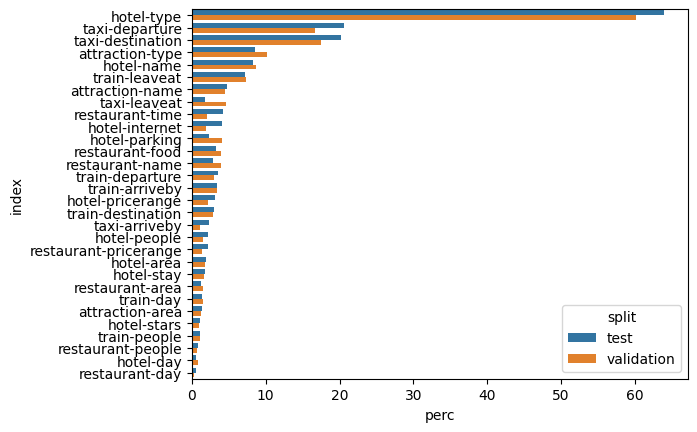

In [78]:
# distribution of most frequent errors

slot_count = (
    pred_df.loc[pred_df["split"] == "validation", "states_24"].map(extract_slots).explode("states_24").value_counts()
)
wrong_slots = (
    pred_df.loc[(pred_df["split"] == "validation") & (pred_df["wrong"] != ()) & (~pred_df["wrong"].isna()), "wrong"]
    .explode("wrong")
    .map(lambda ex: ex[0])
    .value_counts()
)
s = pd.DataFrame({"n": slot_count, "n_wrong": wrong_slots})
s["ratio"] = (s["n_wrong"] / s["n"]) * 100
v_values = s["ratio"].sort_values(ascending=False)
del slot_count, wrong_slots, s

slot_count = pred_df.loc[pred_df["split"] == "test", "states_24"].map(extract_slots).explode("states_24").value_counts()
wrong_slots = (
    pred_df.loc[(pred_df["split"] == "test") & (pred_df["wrong"] != ()) & (~pred_df["wrong"].isna()), "wrong"]
    .explode("wrong")
    .map(lambda ex: ex[0])
    .value_counts()
)
s = pd.DataFrame({"n": slot_count, "n_wrong": wrong_slots})
s["ratio"] = (s["n_wrong"] / s["n"]) * 100
t_values = s["ratio"].sort_values(ascending=False)
del slot_count, wrong_slots, s

plot_data = (
    pd.DataFrame({"test": t_values, "validation": v_values})
    .reset_index()
    .melt(id_vars=["index"], value_name="perc", var_name="split")
    .sort_values("perc", ascending=False)
)
sns.barplot(plot_data, y="index", x="perc", hue="split", orient="h")

In [ ]:
ops_df.loc[ops_df["epoch"] > 10, ["wrong", "over", "under"]].applymap(lambda ex: len(ex) if ex is not None else 0).sum()

In [ ]:
true_df.loc[true_df["dialogue_id"] == "PMUL2088.json"]

In [85]:
pred_df.loc[(~pred_df["under"].isna()) & (pred_df["under"] != ())]

,dialogue_id,turn_id,states,predictions,input_text,previous_states,runtime,batch_size,seq_len,split,epoch,version,model,size,clean_states,slots,new_states,states_21,states_24,jga_turn_21,jga_turn_24,diffs,pred_true,true_pred,wrong,under,over
10,MUL0003.json,0,None,none,dialogue: system: none user: i'm looking for a place to stay. it needs to be a guesthouse and include free wifi. <sep> history: none <sep> previous states: taxi-leaveat = none; restaurant-time = none; hotel-type = none; train-arriveby = none; train-day = none; taxi-destination = none; train-people = none; restaurant-name = none; hotel-stay = none; train-leaveat = none; hotel-parking = none; hotel-day = none; restaurant-area = none; attraction-type = none; restaurant-pricerange = none; hotel-people = none; hotel-pricerange = none; hotel-internet = none; train-destination = none; train-departure = none; restaurant-people = none; restaurant-day = none; taxi-departure = none; taxi-arriveby = none; hotel-area = none; hotel-stars = none; restaurant-food = none; attraction-area = none; attraction-name = none; hotel-name = none,"{'attraction-area': 'none', 'attraction-name': 'none', 'attraction-type': 'none', 'hotel-area': 'none', 'hotel-day': 'none', 'hotel-internet': 'none', 'hotel-name': 'none', 'hotel-parking': 'none', 'hotel-people': 'none', 'hotel-pricerange': 'none', 'hotel-stars': 'none', 'hotel-stay': 'none', 'hotel-type': 'none', 'restaurant-area': 'none', 'restaurant-day': 'none', 'restaurant-food': 'none', 'restaurant-name': 'none', 'restaurant-people': 'none', 'restaurant-pricerange': 'none', 'restaurant-time': 'none', 'taxi-arriveby': 'none', 'taxi-departure': 'none', 'taxi-destination': 'none', 'taxi-leaveat': 'none', 'train-arriveby': 'none', 'train-day': 'none', 'train-departure': 'none', 'train-destination': 'none', 'train-leaveat': 'none', 'train-people': 'none'}",1.541841,12,251,test,0,v1,mwoz21_ops_somdst_lower_2022-12-21T23-50-46,base,None,[],None,"{'hotel-internet': ['yes'], 'hotel-type': ['guesthouse']}","{'hotel-internet': ['yes'], 'hotel-type': ['guest house']}",False,False,"{'true-pred': {'hotel-internet': ['yes'], 'hotel-type': ['guest house']}}",None,"((hotel-internet, yes), (hotel-type, guest house))",None,"((hotel-internet, (yes,)), (hotel-type, (guest house,)))",None
16,MUL0003.json,0,{'hotel-internet': 'yes'},INSERT hotel-internet = yes ; INSERT hotel-internet = yes,dialogue: system: none user: i'm looking for a place to stay. it needs to be a guesthouse and include free wifi. <sep> history: none <sep> previous states: restaurant-pricerange = none; taxi-leaveat = none; hotel-type = none; hotel-day = none; restaurant-day = none; restaurant-area = none; hotel-pricerange = none; attraction-area = none; hotel-area = none; train-departure = none; taxi-departure = none; hotel-name = none; attraction-type = none; restaurant-name = none; train-leaveat = none; hotel-people = none; attraction-name = none; restaurant-people = none; hotel-parking = none; train-day = none; hotel-internet = none; restaurant-food = none; hotel-stars = none; taxi-arriveby = none; train-people = none; hotel-stay = none; restaurant-time = none; train-destination = none; taxi-destination = none; train-arriveby = none,"{'attraction-area': 'none', 'attraction-name': 'none', 'attraction-type': 'none', 'hotel-area': 'none', 'hotel-day': 'none', 'hotel-internet': 'none', 'hotel-name': 'none', 'hotel-parking': 'none', 'hotel-people': 'none', 'hotel-pricerange': 'none', 'hotel-stars': 'none', 'hotel-stay': 'none', 'hotel-type': 'none', 'restaurant-area': 'none', 'restaurant-day': 'none', 'restaurant-food': 'none', 'restaurant-name': 'none', 'restaurant-people': 'none', 'restaurant-pricerange': 'none', 'restaurant-time': 'none', 'taxi-arriveby': 'none', 'taxi-departure': 'none', 'taxi-destination': 'none', 'taxi-leaveat': 'none', 'train-arriveby': 'none', 'train-day': 'none', 'train-departure': 'none', 'train-destination': 'none', 'train-leaveat': 'none', 'train-people': 'none'}",

In [ ]:
t = ops_df.loc[
    ((~ops_df["wrong"].isna()) | (~ops_df["under"].isna()) | (~ops_df["over"].isna()))
    #  & ops_df["wrong"] != ()) | (~ops_df["under"].isna() & ops_df["under"] != ()) | (ops_df["over"] != ()))
    & (ops_df["wrong"] != ()) & (ops_df["predictions"] != "none") & (ops_df["epoch"] > 3),
    # & (ops_df["model"] == "mwoz22_ops_nohist+prev_2022-11-24T04-26-31"),
    [
        "dialogue_context_repr",
        "dialogue_id",
        "turn_id",
        "sys_utt_24",
        "usr_utt_24",
        "previous_states",
        "predictions",
        "diffs",
        "wrong",
        "under",
        "over",
        "epoch",
        "model",
    ],
]

n_trials = t[["model", "epoch"]].drop_duplicates().shape[0]
t["turn_occurrence"] = t.groupby(["dialogue_id", "turn_id"]).transform("size") / n_trials * 100

t = t.explode("wrong")
t["wrong_slot"] = t["wrong"].map(lambda ex: ex[0] if ex is not None else None)

t = t.drop(columns=["model", "epoch"])
t = t.drop_duplicates(subset=["dialogue_id", "turn_id", "wrong", "under", "over", "dialogue_context_repr"])
t = t.sort_values(
    ["turn_occurrence", "dialogue_id", "dialogue_context_repr", "turn_id"], ascending=[False, True, True, True]
)
# t = t.loc[t.apply(lambda row: row["slot"] in row["predictions"], axis=1)]

In [ ]:
t.head(50)

In [ ]:
wt = t.loc[(~t["wrong"].isna()) & (t["wrong"] != ())].drop(columns=["over", "under"])
wt.loc[(wt.apply(lambda row: row["wrong_slot"] in row["predictions"], axis=1))].head(50)

#### Under-predicted

In [ ]:
t = ops_df.loc[
    (~ops_df["under"].isna()) & (ops_df["under"] != ()) & (ops_df["predictions"] != "none") & (ops_df["epoch"] > 3),
    # & (ops_df["model"] == "mwoz22_ops_nohist+prev_2022-11-24T04-26-31"),
    [
        "dialogue_context_repr",
        "dialogue_id",
        "turn_id",
        "sys_utt_24",
        "usr_utt_24",
        "previous_states",
        "predictions",
        "diffs",
        "under",
        "epoch",
        "model",
    ],
]

n_trials = t[["model", "epoch"]].drop_duplicates().shape[0]
t["turn_occurrence"] = t.groupby(["dialogue_id", "turn_id"]).transform("size") / n_trials * 100

t = t.explode("under")
t["under_slot"] = t["under"].map(lambda ex: ex[0] if ex is not None else None)

t = t.drop(columns=["model", "epoch"])
t = t.drop_duplicates(subset=["dialogue_id", "turn_id", "under", "dialogue_context_repr"])
t = t.sort_values(
    ["turn_occurrence", "dialogue_id", "dialogue_context_repr", "turn_id"], ascending=[False, True, True, True]
)
# t = t.loc[t.apply(lambda row: row["slot"] in row["predictions"], axis=1)]

In [ ]:
t["under_slot"].value_counts().plot.barh()